In [5]:
!pip install sagemaker

    100% |████████████████████████████████| 194kB 2.0MB/s ta 0:00:01
    100% |████████████████████████████████| 1.4MB 1.7MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/51/56/5745e66b33846e92a8814466c163f165a26fadad8b33afe381e8b6c3f652/docker_compose-1.24.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ff/17/5cbb026005115301a8fb2f9b0e3e8d32313142fe8b617070e7baad20554f/requests-2.20.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/3b/86/85c1be2e8db9e13ef9a350aecd6dea292bd612fa288c2f40d035bb750ded/cached_property-1.5.1-py2.py3-none-any.whl
    100% |████████████████████████████████| 143kB 2.4MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/29/19/44753eab1fdb50770ac69605527e8859468f3c0fd7dc5a76dd9c4dbd7906/websocket_client-0.56.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f5/e8/f6bd1eee09314e7e6dee49cbe2c5e22314ccdb38db16c9fc72d2fa80d054/docker_pycreds-

# Blog post 2: Getting hands-on with Linear Learner and Amazon SageMaker

# Introduction

In this second part of the three-part blog series, I provide an introduction to inner-workings of Amazon SageMaker and Amazon LinearLearner algorithm. Then I will download [Visa dataset from Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud/data) from an Amazon S3 location to my notebook instance and pre-process it in order to feed the data to the algorithm. We then create a live endpoint and make predictions using trained models.

# Prerequisites
For this series of blog posts, I assume that you have already completed the following tutorials from the Amazon SageMaker documentation:

- [Setting up](https://docs.aws.amazon.com/sagemaker/latest/dg/gs-set-up.html) 
- [Create am Amazon SageMaker Notebook Instance](https://docs.aws.amazon.com/sagemaker/latest/dg/gs-setup-working-env.html)

I have included “sagemaker” in the name of my S3 bucket, "cyrusmv-sagemaker-demos' and have chosen to let any SageMaker notebook instance access any Amazon S3 bucket with the term “sagemaker” included in the name. Note: This is not a recommended security option for production and is only useful for simplifying the flow of the blog.

In this blog I am using the [Visa dataset from Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud). I have put the dataset in an Amazon S3 bucket. You should also download the dataset and upload the data onto Amazon S3, otherwise you will receive errors.

I assume that you are familiar with linear regression. If you’re not, read [blog post one](linearlearner-blogpost-part1.ipynb) in this series.


# Amazon SageMaker
Amazon SageMaker is a fully managed machine learning (ML) service that automates the end-to-end ML process. With Amazon SageMaker, data scientists and developers can quickly and easily build and train machine learning models and directly deploy them into a production-ready hosted environment. Amazon SageMaker provides a hosted Jupyter authoring notebook instance for easy access to your data sources for exploration and analysis, so you don't have to manage servers. It also provides common machine learning algorithms that are optimized to run efficiently against extremely large data in a distributed environment. With native support for bring-your-own-algorithms and frameworks, Amazon SageMaker offers flexible distributed training options that adjust to your specific workflows. You can deploy a model into a secure and scalable environment with a single click from the Amazon SageMaker console. 

The Amazon SageMaker [Python SDK](https://github.com/aws/sagemaker-python-sdk) is an open source high-level python library that simplifies your training and deployment experience in Amazon SageMaker. We will use this SDK in our examples below. The Python SDK provides you with the ability to use Amazon algorithms, train and deploy your own code (currently MXNet and TensorFlow) using Amazon SageMaker, and bring your own pre- trained Dockerized models. 

Let’s take a look at the architecture of Amazon SageMaker. Training workloads, for an end-to-end model development 
includes the following components: 
- Amazon S3 bucket for the training dataset 
- Amazon SageMaker notebook instance, a fully managed single tenant EC2 instance. 
- Amazon Elastic Compute Cloud (EC2) cluster for training (fully managed transparent to developer). 
- Amazon S3 bucket for trained model hosting 

![SageMaker Architecture](https://docs.aws.amazon.com/sagemaker/latest/dg/images/ironman-architecture.png)

# Prepare the data
## Download and host the data in Amazon S3
1. Download the [Visa dataset from kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud/data) to your local machine.
2. Upload the dataset to Amazon S3. You can use the Amazon S3 console to do this.. Remember that I am using an Amazon S3 bucket whose name includes the term "sagemaker." The rest of this blog assumes that you have uploaded the dataset to Amazon S3.

In [3]:
#imports
import boto3 #AWS python SDK for accessing AWS services
import pandas as pd #Tabular data structure
import numpy as np #Array libraru with probability and statistics capabilities
import matplotlib.pyplot as plt # Plotting library
import seaborn as sns #plotting library
import io
import sagemaker.amazon.common as smac # Amazon Sagemaker common library that includes data formats
import sagemaker #sagemaker python sdk
import os
from sagemaker.predictor import csv_serializer, json_deserializer #sagemaker prediction sdk

In [4]:
!pip3 install sagemaker

#Public Variables
bucket = 'cyrusmv-sagemaker-demos'     #replace this with your own bucket 
original_key = 'visa-kaggle/original.csv'    #replace this with your own file inside the bucket
protocol="s3://"
local_origin_data = '/tmp/original.csv'
local_pickel_root = '../data/'
dist = 'visa-kaggle/data/'
s3_4_output = 'visa-kaggle/'
 
# Define IAM role
#import boto3
#import re
from sagemaker import get_execution_role
role = get_execution_role() #this is SageMaker role that would be later used for authorizing SageMaker to access S3
print(role) 

sagemaker_session = sagemaker.Session()

You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


MissingServiceIdError: The model being used for the service sagemaker is missing the serviceId metadata property, which is required.

## Pre-processing the data
***Note:***_If you are not interested in pre-processing data and want to directly proceed to training, please skip ahead to Amazon SageMaker Process: Training._ 

Pre-processing the data includes the following steps:
1.	Download the file locally.
2.	Load file into Pandas for inspection.
3.	converting Pandas DataFrame to numpy.
4.	Shuffle the data.
5.	Split the data into test and validation.
6.	Break up each data set to data and label.
7.	Save the data for later use in pickle files.
8.	Upload the pickle files to Amazon S3.

In [3]:
!pip install sagemaker


    100% |████████████████████████████████| 153kB 1.5MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/eb/a7/042722bc48082f6b02498ebdf4e64a6d1b4543271d4f2f495641f429c56d/protobuf-3.5.2.post1-cp36-cp36m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
  Running setup.py bdist_wheel for sagemaker ... done
  Stored in directory: /Users/cyrusmv/Library/Caches/pip/wheels/12/f0/ee/bd15953fe6c78a5a318d6ec1af4b71f36aaee4a3a1a9b703f5
Successfully built sagemaker
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### 1- Downloading the file locally

In [5]:
#Downloading the file to a local folder
s3 = boto3.resource('s3')
s3.Bucket(bucket).download_file(original_key, local_origin_data)
os.path.isfile(local_origin_data) #checking if the file exists


True

### 2- Loading file into Pandas for inspection

In [6]:
# loading data into pandas for inspection
df = pd.read_csv(local_origin_data)
print(df.as_matrix().shape)

(284807, 31)


/Users/cyrusmv/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


**Data Dimension**: The shape of data is $284807 \times 31$, meaning that $dim(input\_data)\ = \ 1$. Next we want to distinguish features from the target.

In [11]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [12]:
# We would like to see what values we have for "Class". This snippet below shows that Class is a binary column.
print()
print(df.groupby('Class').size())


Class
0    284315
1       492
dtype: int64


** Feature and target identification**
*"Class"* is our target and the rest of the columns are our features. Next we want to understand values or clusters of *"Class"*.

This tells us that we are predicting a binary target and instead of linear regression, we should be performing a logistic regression or binary classification.

So far we know that the following:
- Of the 31 input dimensions, 30 are features and *'Class'* is the target.
- The target is a binary prediction thus our linear regression function would be defined as:

$$
f:\mathbb{R}^{30} \rightarrow \{0, 1\} \\
f(x) = W_{30 \times 1} V_{1 \times 30} + b
$$

**Data Normalization:** As the last observation, we want to check data distribution to see whether or not the data is normalized by plotting all the columns. We often would like the data to be within a comparable range with the same center and perhaps similar standard deviation, so numerical value ranges would not create bias towards some features. This however is not always the case. For instance if we would like one feature to have a bigger impact, we can simply let it. The following is the box plot from our data set. We can see that apart from 'Time' and 'Amount', the rest of the data is normalized, so I assume Visa wanted 'Time' and 'Amount' to have a much higher impact.

***AmazonSageMaker Tip: Amazon LinearLearner normalizes the data by default. If your want to prevent data normalization you will have to change the value of*** `normalize_data` ***to*** `false` ***in the hyperparameters.***

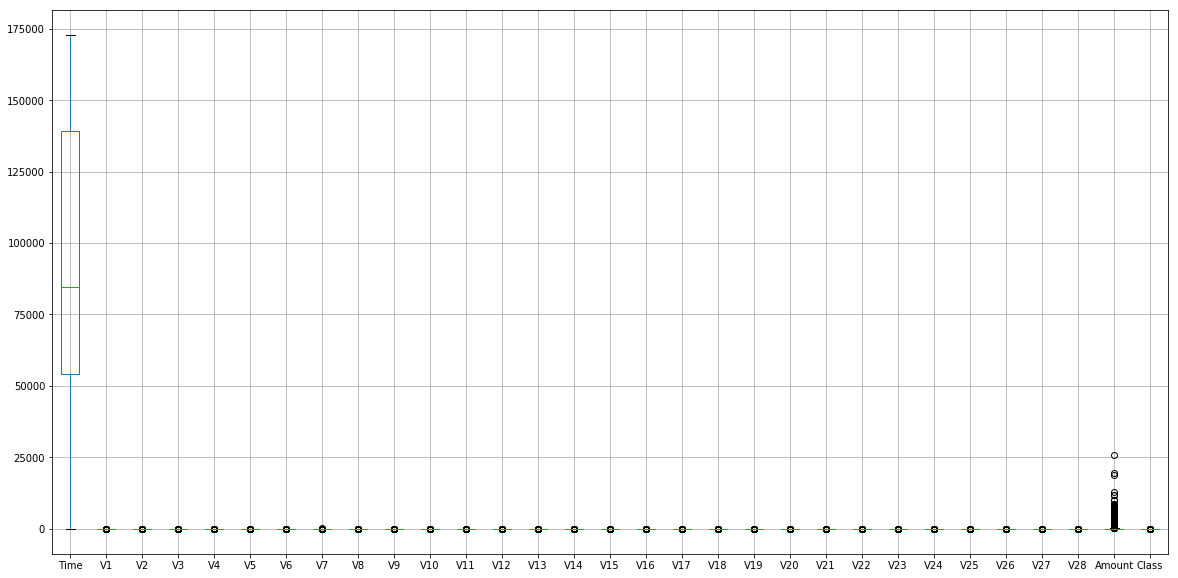

In [13]:
df.boxplot(figsize=(20, 10))
plt.show()

In [ ]:
df.Class.plot.pie()

Dropping "Time", "Amount", and "Class", we can observer the distribution with greater detail. Here not all columns are centered around the same point (0 in this case)

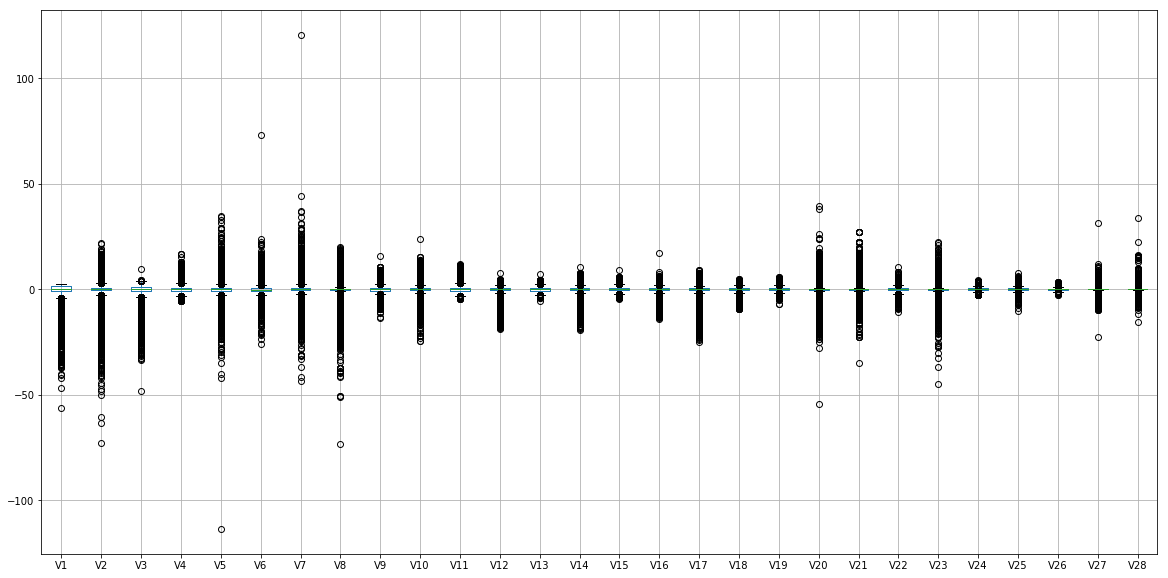

In [82]:
df1 = df.drop(['Time', 'Amount', 'Class'], axis=1)
df1.boxplot(figsize=(20, 10))
plt.show()


### 3- Converting Pandas data frame to numpy

In [83]:
#Converting Data Into Numpy
raw_data = df.as_matrix()

### 4- Shuffling the data

In [100]:
num_recs = np.float32(df['Class'].count())
num_zeros = df['Class'][df['Class']==0].count()
num_ones = num_recs - num_zeros
print("{}% of transactions are fraudunat and {}% are legitimate".format((num_ones/num_recs)*100,
                                                                       (num_zeros/num_recs*100)))


0.172748563062% of transactions are fraudunat and 99.8272514369% are legitimate


We know from previous code snippet that **99.8** percent of our transactions are legitimate, so it is crucial to randomize distribution of Class==1 within the dataset, so we do not end up with a lumpy concentration of most of Class==1 in a segment of dataset 

To randomize distribution of Class==1, we shuffle the data in the dataset.

There are three issues with Class==1 being concentrated near one another:
1. We might learn sequential noise
2. We might unlearn what we have learned as we iterate down in the dataset.
3. The dataset includes both training and validation sets and we need to split the data. with a distribution that is not normal and smooth, we might end up with most or all of Class==1 in training or validation.



In [116]:
#Shuffling the data and randomizing the distrbution of the data
#I have performed to shuffles and experimented with different seeds until the distribution 
#of Class==1 became acceptably smooth according to the graph below.
np.random.seed(13)
np.random.shuffle(raw_data)
np.random.seed(49)
np.random.shuffle(raw_data)

### 5- Breaking up each data set to data and label

In [117]:
label = raw_data[:, -1] #Taking last column of the data and creating a lanel vector
data = raw_data[:, :-1] # Taking the remains of th da

print("shape before split: {}; label_shape = {}; data_shape= {}".format(raw_data.shape, label.shape, data.shape))

shape before split: (284807, 31); label_shape = (284807,); data_shape= (284807, 30)


From the previous snippet we see that the original dataset has 31 columns (dimensions) and now we have two vectors, the data vector with 30 rows and label is just a scalar.

**Plotting distribution of Class==1:** Next we want to be sure that Class==1 records are distributed evenly within the dataset before we attempt to split the data to training and validation.

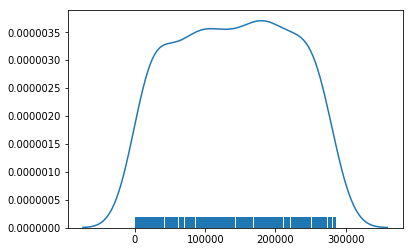

In [118]:
# There are very few fraudulent transactions in the dataset, so I am putting their indexes in an array
# to plot and ensure they are evenly distributed, so when I split the dataset into test and training 
# I don't end up with a disproportionate distribution
t = []
for i in range(len(label)):
    if label[i] == 1:
        t.append(i)

sns.distplot(t, kde=True, rug=True, hist=False)
plt.show()

This plot shows the distribution of Class==1. The blue bar at the bottom (rug==True) shows us that Class==1 is evenly distributed within the range of the data [0..284807]. From this plot  we can observe that 

### 6- Splitting data into test and validation
The data is split 70-30 for training and validation

In [119]:
#Splitting data into validation and training and breaking dataset into data and label

#70%-30% training to validation
train_size = int(data.shape[0]*0.7)

#training data and associated labels
train_data  = data[:train_size, :]
val_data = data[train_size:, :]

#validation data and associated labels
train_label = label[:train_size]
val_label = label[train_size:]


print("training data shape= {}; training label shape = {} \nValidation data shape= {}; validation label shape = {}".format(train_data.shape, 
                                                                        train_label.shape,
                                                                        val_data.shape,
                                                                        val_label.shape))

training data shape= (199364, 30); training label shape = (199364,) 
Validation data shape= (85443, 30); validation label shape = (85443,)


### 7- Saving data for later use
Pre-processing data could take time. Therefore, I strongly recommend that you save the pre-processed data, using the appropriate format. This way you can save your pre-processed data for later use as well as share the data with your teammates. I am using numpy’s save and use pickle format.

In [120]:
#Saving arrays for later use
np.save(local_pickel_root + 'train/train_data.npy', train_data, allow_pickle=True)
np.save(local_pickel_root + 'train/train_label.npy', train_label, allow_pickle=True)
np.save(local_pickel_root + 'test/val_data.npy', val_data, allow_pickle=True)
np.save(local_pickel_root + 'test/val_label.npy', val_label, allow_pickle=True)

!ls -R '../data/'


../data/:
test  train  visa-kaggle

../data/test:
val_data.npy  val_label.npy

../data/train:
train_data.npy	train_label.npy

../data/visa-kaggle:
data

../data/visa-kaggle/data:
recordio-pb-data  test	train

../data/visa-kaggle/data/test:
val_data.npy  val_label.npy

../data/visa-kaggle/data/train:
train_data.npy	train_label.npy


### 8- Uploading the pickle files to S3
Uploading the data helps you reuse and share the pre-processed data.

In [121]:
#Uploading the data.
'''
path is the local path on your notebooks instance
bucket is your bucket name
key_prefix is your folder structure inside you S3 bucket
'''
S3loc = sagemaker_session.upload_data(path=local_pickel_root, bucket=bucket, key_prefix='visa-kaggle/data')
print(S3loc)
!aws s3 ls cyrusmv-sagemaker-demos/visa-kaggle/data/ --recursive #use the output from your own S3loc

s3://cyrusmv-sagemaker-demos/visa-kaggle/data
2018-01-04 12:19:10          0 visa-kaggle/data/
2018-03-13 09:58:57   33493152 visa-kaggle/data/recordio-pb-data
2018-04-05 14:55:22   20506400 visa-kaggle/data/test/val_data.npy
2018-04-05 14:55:22     683624 visa-kaggle/data/test/val_label.npy
2018-04-05 14:55:18   47847440 visa-kaggle/data/train/train_data.npy
2018-04-05 14:55:17    1594992 visa-kaggle/data/train/train_label.npy
2018-04-05 14:55:19   33493152 visa-kaggle/data/visa-kaggle/data/recordio-pb-data
2018-04-05 14:55:22   20506400 visa-kaggle/data/visa-kaggle/data/test/val_data.npy
2018-04-05 14:55:21     683624 visa-kaggle/data/visa-kaggle/data/test/val_label.npy
2018-04-05 14:55:20   47847440 visa-kaggle/data/visa-kaggle/data/train/train_data.npy
2018-04-05 14:55:20    1594992 visa-kaggle/data/visa-kaggle/data/train/train_label.npy


# Amazon SageMaker Process: Training
Amazon SageMaker built-in algorithms requires you to follow a certain number of steps for training:

## Preparation
1.	Convert the data to a supported format for Amazon SageMaker. All algorithms support recordio-protobuf. Some algorithms like linear learner also support CSV. In this post we are using recordio.
2.	Upload the converted data to Amazon S3. This location is required to be passed to fit the function, which preforms training.
3.	Passing an Amazon S3 location to your train function, so that model artifacts after training will be uploaded to Amazon S3.

### 1- Converting data to recordio-protibuf
First we will make sure that we have the data locally, and we load the pickled data into numpy vectors.

In [123]:
train_data = np.load(local_pickel_root + 'train/train_data.npy')
train_label = np.load(local_pickel_root + 'train/train_label.npy')

val_data = np.load(local_pickel_root + 'test/val_data.npy')
val_label = np.load(local_pickel_root + 'test/val_label.npy')

print("training data shape= {}; training label shape = {} \nValidation data shape= {}; validation label shape = {}".format(train_data.shape, 
                                                                        train_label.shape,
                                                                        val_data.shape,
                                                                        val_label.shape))
train_set = (train_data, train_label)
test_set = (val_data, val_label)


training data shape= (199364, 30); training label shape = (199364,) 
Validation data shape= (85443, 30); validation label shape = (85443,)


**Converting the data**: 
The Linear Learner algorithm supports CSV and recordio/protobuf. recordio is faster than CSV and especially in algorithms that deal with sparse matrices. In the following snippet I am using sagemaker.amazon.core library to convert my numpy arrays into protobuf recordIO.

In [124]:
vectors = np.array([t.tolist() for t in train_set[0]]).astype('float32')
labels = np.array([t.tolist() for t in train_set[1]]).astype('float32')

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)

0L

### 2- Uploading the converted data to Amazon S3
Now that we've created our recordIO-wrapped protobuf, we'll need to upload it to Amazon S3, so that Amazon SageMaker training can use it.

In [126]:
key = 'recordio-pb-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(dist, key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}{}'.format(bucket, dist, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://cyrusmv-sagemaker-demos/visa-kaggle/data/recordio-pb-data


### 3-Passing an Amazon S3 location to your train function
Let's also setup an output Amazon S3 location for the model artifacts to be uploaded to after training in complete.

In [127]:
output_location = 's3://{}/{}output'.format(bucket, s3_4_output)
print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://cyrusmv-sagemaker-demos/visa-kaggle/output


### The end of the data preparation phase
At this point we have a set of npy training and validation files in Amazon S3, and we no longer need the local data. This tutorial up to here can be split into a separate notebook. In fact I strongly recommend that you do this. Next, we are going to train the Linear Learner model with the Visa dataset. First, I will dive deeper into Amazon SageMaker Python SDK.

## Training LinearLearner using the Amazon SageMaker Python SDK
### Architecture
Before diving into the code, let’s get under the hood of Amazon SageMaker and see how it works. The Amazon SageMaker Python SDK has a few core classes. The most important class hierarchy for training jobs is the Estimator.

The base class, EstimatorBase, has a method, called ```python fit()```. All classes that are derived from EstimatorBase implement ```python fit()```.

Calling ```python fit()``` results in creating a training job, spinning up a training cluster, and training the model. After the training is complete, the trained model artefacts will be saved in S3 and training cluster will be torn down.

Ignoring Frameworks and other built-in algorithms we can see that EstimatorBase branches into two sections, general Estimator, used for calling Amazon Algorithms, and FrameWork from which the Estimators class for using frameworks such as MXNet and TensorFlow are derived.
![EstimatorHierarchy](../images/estimator.png)

### Training
Training a model in Amazon SageMaker consists of creating an Estimator object, setting hyperparameters, and calling ```python fit()```. 
The core below shows how to create an Estimator object, pass hyperparameters to it, and call the ```fit``` method.

```python
linear = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                       role, #S3 role, so the notebook can read the data and upload the model
                                       train_instance_count=1, #number of instances for training
                                       train_instance_type='ml.p2.xlarge', # type of training instance
                                       output_path=output_location, #s3 location for uploading trained mdoel
                                       sagemaker_session=sess)
linear.set_hyperparameters(feature_dim=30, #dataset has 30 columns (features)
                           predictor_type='binary_classifier', # for regression set to regressor
                           mini_batch_size=200)

linear.fit({'train': s3_train_data})                                
                                    
```
Calling fit will create the follwing flow:
1. Creation of a training cluster based on requested specification will be created.
2. Creating and launching of a Training Job by Amazon SageMaker.
3. Streaming or downloading of training dataset from S3 onto the training cluster.
4. Training will be performed based on the values of hyperparameters.
5. Training will terminate after termination criteria is reached.
6. Model artefacts of the best model will be uploaded to designated S3 location.
7. The training cluster is torn down.

### Training - Code
We need to tell the Estimator where the model is located. Linear Learner is hosted in Amazon ECR Docker registry in several Regions. Pass the appropriate image to the Estimator object.

I then define a set of hyperparameters for LinearLearner to tune the model. First, we perform the training with default values and later we attempt to optimize model performance by changing from default values for hyperparameters to more targeted values based on performance indicators. In this case we are targeting higher recall.

Finally we call the ```fit()``` method of the Estimator object.

In [19]:
#list of LinearLearner containers
containers = {'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/linear-learner:latest',
              'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:latest',
              'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/linear-learner:latest',
              'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/linear-learner:latest'}

In [20]:
sess = sagemaker.Session()

#Instantiating Estimator
linear = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                       role, #S3 role, so the notebook can read the data and upload the model
                                       train_instance_count=1, #number of instances for training
                                       train_instance_type='ml.p2.xlarge', # type of training instance
                                       output_path=output_location, #s3 location for uploading trained mdoel
                                       sagemaker_session=sess)

#Setting hyperparameters
linear.set_hyperparameters(feature_dim=30, #dataset has 30 columns (features)
                           predictor_type='binary_classifier', # we predict a binary value. it could have been regressor
                           mini_batch_size=200)

#Calling fit that results in training the model
linear.fit({'train': s3_train_data})

INFO:sagemaker:Creating training-job with name: linear-learner-2018-03-13-09-59-05-546


...........................................................................
Docker entrypoint called with argument(s): train
[03/13/2018 10:05:15 INFO 139642387044160] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'epochs': u'10', u'init_bias': u'0.0', u'lr_scheduler_factor': u'0.99', u'num_calibration_samples': u'10000000', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'bias_lr_mult': u'10', u'lr_scheduler_step': u'100', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'0.00001', u'target_recall': u'0.8', u'num_models': u'32', u'early_stopping_patience': u'3', u'momentum': u'0.0', u'unbias_label': u'auto', u'wd': u'0.0', u'optimizer': u'adam', u'early_stopping_tolerance': u'0.001', u'learning_rate': u'auto', u'_kvstore': u'auto', u'normalize_data': u'true', u'binary_classifier_model_selection_criteria': u'accuracy', u'use_lr_sche

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.00566765322847419, "sum": 0.00566765322847419, "min": 0.00566765322847419}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520935595.519038, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1520935595.518941}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004825514521464765, "sum": 0.004825514521464765, "min": 0.004825514521464765}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520935595.519132, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1520935595.519108}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, 

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.0049351280024013365, "sum": 0.0049351280024013365, "min": 0.0049351280024013365}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520935633.60766, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1520935633.607577}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004272033306152885, "sum": 0.004272033306152885, "min": 0.004272033306152885}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520935633.607753, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1520935633.607729}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count"

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.0047066798815167095, "sum": 0.0047066798815167095, "min": 0.0047066798815167095}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520935671.675466, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1520935671.675338}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004219565435413675, "sum": 0.004219565435413675, "min": 0.004219565435413675}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520935671.675576, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1520935671.675553}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004611711336905698, "sum": 0.004611711336905698, "min": 0.004611711336905698}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520935709.738447, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1520935709.738363}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.0041053236841811355, "sum": 0.0041053236841811355, "min": 0.0041053236841811355}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520935709.738542, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1520935709.738518}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004567882297149145, "sum": 0.004567882297149145, "min": 0.004567882297149145}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520935747.893205, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1520935747.893123}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004108989604124163, "sum": 0.004108989604124163, "min": 0.004108989604124163}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520935747.893306, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1520935747.893272}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004545868605704432, "sum": 0.004545868605704432, "min": 0.004545868605704432}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520935786.02129, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1520935786.021163}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.00404934419876331, "sum": 0.00404934419876331, "min": 0.00404934419876331}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520935786.021398, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1520935786.021376}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004526677778192672, "sum": 0.004526677778192672, "min": 0.004526677778192672}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520935825.535233, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1520935825.535151}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.0040510251828241185, "sum": 0.0040510251828241185, "min": 0.0040510251828241185}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520935825.535328, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1520935825.535304}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004505496464639783, "sum": 0.004505496464639783, "min": 0.004505496464639783}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520935863.76322, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1520935863.763132}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004010293117862748, "sum": 0.004010293117862748, "min": 0.004010293117862748}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520935863.763306, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1520935863.763287}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004484349691110802, "sum": 0.004484349691110802, "min": 0.004484349691110802}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520935901.91758, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1520935901.91745}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.00402259058017942, "sum": 0.00402259058017942, "min": 0.00402259058017942}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520935901.917689, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1520935901.917666}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, 

===== Job Complete =====


### Monitoring your training job
Amazon SageMaker has logs training using Amazon CloudWatch. The logs are located under aws/TrainingJobs
![training logs](../images/logging.png)

Amazon SageMaker also provides a set of Metrics. Metrics include:
- Memory Utilization
- CPU Utilization
- GPU Utilization
- Disk Utilization
You can use these metrics to size your training cluster accordingly.

We would also measure whether we have chosen the correct Amazon EC2 profile for the model training. The following screenshot shows utilization of the resources.
The picture below shows that our GPU in underutilized. Generally for a linear model, a p2 instance is an overkill.

![util](../images/underutilization.png)


# Amazon SageMaker process - Hosting the model
Now that we have completed and saved the training job, we can venture into creating endpoints. Amazon SageMaker requires a single line of code in order to create a fully managed and elastically scalable endpoint environment. 

Amazon SageMaker takes your model artefacts from the Amazon S3 bucket and Dockerizes them. It also creates an [Amazon ECS (Amazon Elastic Container Service)](https://aws.amazon.com/documentation/ecs/) infrastructre, fronted with an [ELB or ElasticLoadBalncer](https://aws.amazon.com/documentation/elastic-load-balancing/).

The instances are also members of an [Auto Scaling Group](https://docs.aws.amazon.com/autoscaling/ec2/userguide/AutoScalingGroup.html), meaning that based on the incoming load the number of underlying EC2 instances can grow and shrink dynamically. 

Model hosting is independent of how you develop your models, meaning that you do not need to develop your model within Amazon SageMaker or use Amazon Algorithms in order to host your models in Amazon SageMaker. 

This blog is focused on LinearLearner. So hosting your own models is out of the scope of this blog post. For more information please refer to [Amazon SageMaker doumentation](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms.html)

From the class diagram we delved into previously, we can remember that EstimatorBase implements a method called `deploy()`. All the deployment magic happens through a single call to `Estimator.deploy()`

We pass initial cluster size and instance type to `deploy()`. 
```python
linear_predictor = linear.deploy(initial_instance_count=1, #Initial number of instances. 
                                                           #Autoscaling can increase the number of instances.
                                 instance_type='ml.m4.xlarge') # instance type
```


## Model class hierarchy
![Model](../images/model.png)


## Predictor Class 
![predictor](../images/predictor.png)


In [21]:
linear_predictor = linear.deploy(initial_instance_count=1, #Initial number of instances. 
                                                           #Autoscaling can increase the number of instances.
                                 instance_type='ml.m4.xlarge') # instance type

INFO:sagemaker:Creating model with name: linear-learner-2018-03-13-10-26-27-683
INFO:sagemaker:Creating endpoint with name linear-learner-2018-03-13-09-59-05-546


---------------------------------------------------------------------------------------------------------------!

In [57]:
type(linear_predictor)

sagemaker.predictor.RealTimePredictor

## SageMaker process - Prediction
`Estimator.deploy()` eventually returns a `sagemaker.predictor.RealTimePredictor` object. `sagemaker.predictor.RealTimePredictor` implements a method called `predict()`, which is used to make live predictions.

Predictors in Amazon Sagemaker accept CSV and JSON. In this blog we use JSON serialization.

In [58]:
linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

Since Fraudulent records are rare, I have created an array of all records in a validation set with *"Class==1"* in order to test model accuracy by testing the predictor endpoint on ranges that in fact includes fraudulent transactions.

You can observe that record number 516 is correctly predicted to be a fraud when we would run prediction in range of 515-519, as is shown in the following snippet.

*
{'predictions': [{'score': 0.0006907652714289725, 'predicted_label': 0.0}, **{'score': 0.9957004189491272, 'predicted_label': 1.0}**, {'score': 0.0006745134014636278, 'predicted_label': 0.0}, {'score': 0.0006603851797990501, 'predicted_label': 0.0}]}
*

In [59]:
#since score==1 is very rare we want to make sure we can correctly predict fradulant transaction. 
#First we print a lost of all labels where score == 1, then then run a prediction
t = []
for i in range(len(train_label)):
    if train_label[i] == 1:
        t.append(i)
        
print(t)

print('\n')
print(linear_predictor.predict(train_set[0][515:519]))


[516, 765, 867, 2636, 2704, 3360, 3583, 4111, 4482, 5115, 6463, 7810, 8008, 8420, 9171, 9178, 10236, 10591, 10604, 10701, 11363, 13516, 14479, 15167, 15396, 15949, 16334, 16348, 16982, 17309, 17698, 18155, 19023, 19048, 19116, 20236, 20382, 20701, 21038, 21080, 21509, 22228, 24887, 25425, 25840, 26055, 26797, 27138, 27982, 28853, 30106, 30733, 31027, 31317, 31353, 32757, 33018, 33285, 33710, 34422, 34926, 35447, 35595, 35699, 35700, 35922, 37207, 39095, 39165, 39623, 39954, 40098, 40486, 41384, 41871, 42159, 43274, 43573, 43641, 43798, 43949, 44281, 44954, 45959, 46102, 48351, 48763, 49023, 49041, 49576, 52158, 52165, 53136, 54002, 54994, 57241, 57242, 58254, 58297, 58298, 58707, 59283, 59350, 59791, 59795, 59966, 59981, 60137, 60226, 60260, 60705, 62107, 62426, 64015, 64309, 64645, 65028, 66338, 68281, 69096, 69159, 69280, 69344, 69487, 69530, 71003, 71055, 71580, 72302, 73057, 73358, 73389, 73644, 75015, 75384, 77773, 77821, 77843, 78179, 79448, 79479, 80184, 82184, 82484, 83329, 852

In [60]:
non_zero = np.count_nonzero(test_set[1])
zero = len(test_set[1]) - non_zero
print("validation set includes: {} non zero and {} items woth value zero".format(non_zero, zero))

validation set includes: 147 non zero and 85296 items woth value zero


In [61]:
predictions = []
for array in np.array_split(test_set[0], 100):
    result = linear_predictor.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]

predictions = np.array(predictions)

In [63]:
import pandas as pd

pd.crosstab(test_set[1], predictions, rownames=['actuals'], colnames=['predictions'])

predictions,0.0,1.0
actuals,,
0.0,85265,31
1.0,29,118


### Analyzing the Results
The confusion matrix above indicates that:
- Total fraudulent transactions: 147
 - Num Examples (NE) = 85443
 - True Positive (TP) = 118
 - False Positive (FP) = 31
 - False Negative (FN) = 29

- **Recall** = TP/(TP+FN) = 118/(118+29) = 0.80
- **Precision** = TP/(TP+FP) = 118/(118+31) = 0.79
- **Accuracy** = 1- (FP+FN)/NE = 1 - (60/85443) = 0.99

The model produces a superb accuracy, but how about precision and recall? Can we improve recall to be able to pick out more fraudulent transactions accurately?

We can optimize the model to balance between recall and precision. In [blog post three, "Excel in tuning models using Amazon LinearLearner algorithm"](linearlearner-blogpost-part3.ipynb), I will attempt to tune the model to prioritize recall over accuracy and report the results. 

The model performance is based on default parameters that are located in training instances in `/opt/ml/input/config/hyperparameters.json`

The default parameters are:

u'epochs': u'10', u'init_bias': u'0.0', u'lr_scheduler_factor': u'0.99', u'num_calibration_samples': u'10000000', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'bias_lr_mult': u'10', u'lr_scheduler_step': u'100', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'0.00001', **u'target_recall': u'0.8'**, **u'num_models': u'32'**, u'momentum': u'0.0', u'unbias_label': u'auto', u'wd': u'0.0', u'optimizer': u'adam', u'learning_rate': u'auto', u'_kvstore': u'auto', **u'normalize_data': u'true'**, **u'binary_classifier_model_selection_criteria': u'accuracy'**, u'use_lr_scheduler': u'true', **u'target_precision': u'0.8'**, u'force_dense': u'true', u'unbias_data': u'auto', u'init_scale': u'0.07', u'bias_wd_mult': u'0', u'mini_batch_size': u'1000', u'beta_1': u'0.9', u'loss': u'auto', u'beta_2': u'0.999', u'normalize_label': u'auto', u'_num_gpus': u'auto', u'_data_format': u'record', u'positive_example_weight_mult': u'1.0', u'l1': u'0.0'}le_weight_mult': u'1.0', u'l1': u'0.0'}



A detailed description of the parameters can be found [in the Amazon SageMaker documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/ll_hyperparameters.html)

The most likely parameters that could be useful for improving recall are:
- binary_classifier_model_selection_criteria
- target_recall: *If selection criterial is set to prioritized for recall, then this value is ignored*
- target_precision
- num_models


### Monitor the live environment
A key feature of monitoring Amazon SageMaker endpoints is that you do not monitor infrastructure, instead, you are monitoring your models even if they might be deployed on multiple machines. This gives you a holistic view of your model performance.

Amazon Cloud Watch Logs includes /aws/sagemaker/Endpoints per endpoint you create. You can use logs to monitor your model logs including all the calls to your endpoints.

![endpoint_logs](../images/logging.png)
For a graphical view of your metrics you can use Amazon Cloud Watch metrics. You can monitor your model metrics such as:
- GPU Utilization
- CPU Utilization
- Latency
- Memory Utilization

For more information please see the  [Amazon SageMaker documentation](!https://docs.aws.amazon.com/sagemaker/latest/dg/monitoring-overview.html)

The following screenshot is the results of several thousands of endpoint calls I performed on my Linear Learner.

![monitoring](../images/metrics.png)

# Local prediction
It might be useful to download the model created by Amazon SageMaker training, explore the model parameters and use it for predictions locally. The following section is still experimental and the model formats and api may be changed in the future for a better user experience.
First we need to upgrade MXNet.



In [22]:
#upgrading mxnet
!pip install -U mxnet

    100% |████████████████████████████████| 23.8MB 46kB/s  eta 0:00:01
    100% |████████████████████████████████| 16.7MB 71kB/s  eta 0:00:01
Requirement already up-to-date: requests==2.18.4 in /home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages (from mxnet)
Requirement already up-to-date: chardet<3.1.0,>=3.0.2 in /home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages (from requests==2.18.4->mxnet)
Requirement already up-to-date: idna<2.7,>=2.5 in /home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages (from requests==2.18.4->mxnet)
Requirement already up-to-date: urllib3<1.23,>=1.21.1 in /home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages (from requests==2.18.4->mxnet)
    100% |████████████████████████████████| 153kB 7.6MB/s eta 0:00:01
  Found existing installation: numpy 1.14.0
    Uninstalling numpy-1.14.0:
      Successfully uninstalled numpy-1.14.0
  Found existing installation: graphviz 0.8.2
    Uninstalling graphviz-0.8

Then download the trained model from from S3.

In [41]:

model_s3_path = linear.model_data
model_s3_key = "/".join(model_s3_path.split("/")[3:])
boto3.resource('s3').Bucket(bucket).download_file(model_s3_key, 'model.tar.gz')


In [42]:
!ls

linearlearner-blogpost-part1.ipynb  linearlearner-blogpost-part3.ipynb
linearlearner-blogpost-part2.ipynb  model.tar.gz


Next, we extract the model from the tarball.

In [43]:
if not os.path.exists("model"):
    os.mkdir("model")
os.system('tar -zxvf model.tar.gz -C model/')
os.listdir("model")

['model_algo-1']

Linear learner model is itself a zip file called model_algo-1. Lets explore whats in the zip-

In [45]:
os.system('unzip model/model_algo-1 -d model')
os.listdir("model")

['manifest.json',
 'additional-params.json',
 'mx-mod-0000.params',
 'model_algo-1',
 'mx-mod-symbol.json']

The model contains a params file a and a symbol file which is serialized by mxnet, along with other metadata. We are now ready to load the model into mxnet.

In [46]:
import mxnet as mx
mod = mx.module.Module.load("model/mx-mod", 0)

/home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages/mxnet/module/base_module.py:53: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
	out_label
  warnings.warn(msg)


In [47]:
weight = mod._arg_params['fc0_weight'].asnumpy().flatten()
weight

array([  5.14778037e-07,   6.77366927e-02,  -3.98861319e-02,
         2.14127526e-02,   5.64191937e-01,   5.36445566e-02,
        -4.14882898e-02,  -1.21941768e-01,  -1.64590880e-01,
        -2.93201268e-01,  -5.89762866e-01,   1.64103396e-02,
         6.63065410e-04,  -1.73284978e-01,  -6.38051331e-01,
        -1.23316392e-01,  -2.46714443e-01,   7.47996569e-02,
        -4.46788920e-03,   2.05700174e-02,  -2.84751415e-01,
         3.23608547e-01,   5.39889812e-01,  -1.34267092e-01,
         1.07920095e-01,  -3.63967977e-02,  -1.29571691e-01,
        -4.43223298e-01,  -2.10074008e-01,   4.18556534e-04], dtype=float32)

In [48]:
bias = mod._arg_params['fc0_bias'].asnumpy().flatten()
bias

array([-8.55558109], dtype=float32)

In [49]:
test_data_iter = mx.io.NDArrayIter(data=val_data)
mod.bind(test_data_iter.provide_data)
predictions = mod.predict(test_data_iter)

/home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [50]:
import json
additional_params = json.load(open("model/additional-params.json"))
threshold = additional_params["threshold"]
predictions = predictions >= threshold
predictions[0:5]


[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
<NDArray 5x1 @cpu(0)>

In [51]:
dot = np.dot(val_data, weight) + bias
np_predictions = 1 / (1 + np.exp(-dot)) > threshold

In [53]:
pd.crosstab(test_set[1], np_predictions, rownames=['actuals'], colnames=['predictions'])

predictions,False,True
actuals,,
0.0,85266,30
1.0,39,108


# Delete the endpoint
If you're ready to be done with this notebook, please run the delete_endpoint line in the cell below. This will remove the hosted endpoint you created and avoid any charges you could incur from a stray instance being left on.

# What’s next 
In blog post 1, [Blog post one: Linear Regression and Binary Classification, a Friendly Introduction](linearlearner-blogpost-part1.ipynb), I provide you with a basic introduction to linear regression. I also provide references to implement your own linear regression, both from scratch and using MXNet and Gluon.

In the current blog post, [blog post 2, Getting Hands-On with Linear Learner and Amazon SageMaker](linearlearner-blogpost-part2.ipynb), I download the [Visa dataset from Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud/data) from an Amazon S3 location to my notebook instance and pre-process it to feed the data to the algorithm. We can then create a live endpoint and make predictions using trained models. 

NEXT: [Blog post three: Excel in tuning models using the Amazon Linear Learner Algorithm](linearlearner-blogpost-part3.ipynb). In this blog post I attempt to fine-tune the model on the Visa dataset to see whether or not the recall could be improved.


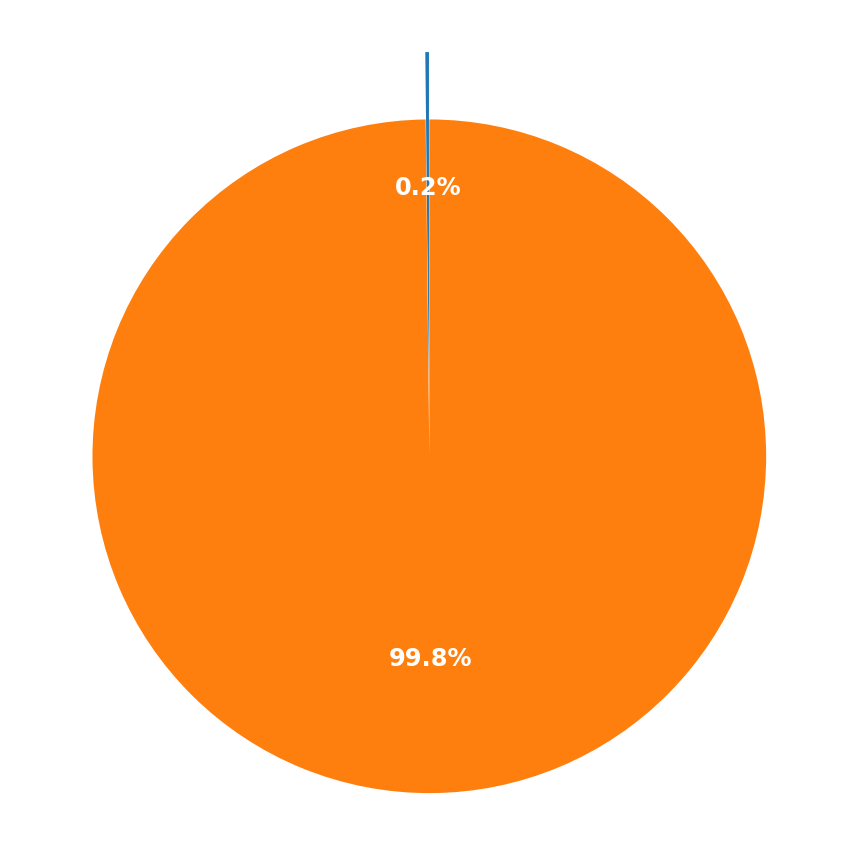

In [21]:
import matplotlib.pyplot as plt
fraudcnt = df.Class[df.Class==1].count()
nfc = df.Class.count() - fraudcnt
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Fraud', 'Not Fraud'
sizes = [fraudcnt, nfc]
explode = (0, .2)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(15, 15))

wedges, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', 
        shadow=False, startangle=90, textprops=dict(color="w"))
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.setp(autotexts, size=24, weight="bold")
plt.setp(texts, size=24, weight="bold")

plt.show()

AttributeError: 'Series' object has no attribute 'boxplot'

In [25]:
import gluonts

In [ ]:
from gluonts.mode